In [1]:
import os
import warnings

import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Modelling utilities 
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform

# Imbalanced‑learning helpers 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


In [2]:
DATA_DIR = os.path.expanduser(
    "~/.cache/kagglehub/datasets/teejmahal20/airline-passenger-satisfaction/versions/1"
)

TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

print(f"✅ Train shape: {df_train.shape}")
print(f"✅ Test  shape: {df_test.shape}")

df_train.head()


✅ Train shape: (103904, 25)
✅ Test  shape: (25976, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


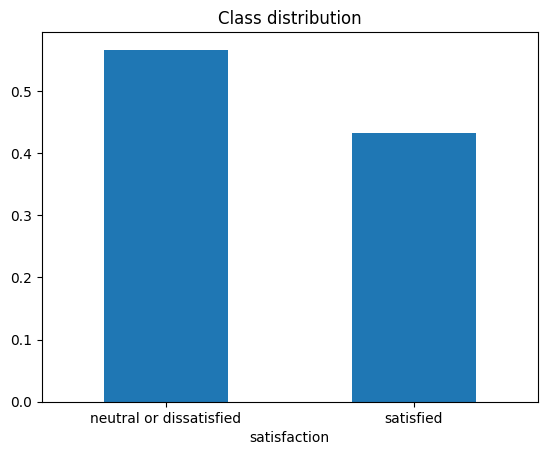

In [3]:
# Identify the target and look at class balance
TARGET_COL = "satisfaction" 
df_train[TARGET_COL].value_counts(normalize=True).plot.bar(rot=0)
plt.title("Class distribution"); plt.show()

# Encode target to 0/1 for scikit‑learn
df_train[TARGET_COL] = (df_train[TARGET_COL] == "satisfied").astype(int)
df_test[TARGET_COL]  = (df_test[TARGET_COL]  == "satisfied").astype(int)


In [4]:
# Quick glance at % missing in each column
(df_train.isna().mean()*100).sort_values(ascending=False).head(10)


Arrival Delay in Minutes      0.298352
Unnamed: 0                    0.000000
Online boarding               0.000000
Departure Delay in Minutes    0.000000
Cleanliness                   0.000000
Inflight service              0.000000
Checkin service               0.000000
Baggage handling              0.000000
Leg room service              0.000000
On-board service              0.000000
dtype: float64

The arrival delay variable has to be imputed. The median is robust to outliers, which is important for delay times that may have extreme values. 

In [5]:
# Impute missing values in 'Arrival Delay in Minutes' with the median
median_val = df_train["Arrival Delay in Minutes"].median()
df_train["Arrival Delay in Minutes"].fillna(median_val, inplace=True)
df_test["Arrival Delay in Minutes"].fillna(median_val, inplace=True)


/var/folders/c2/1d1qzk1s6515n9mmmjl_7b0m0000gn/T/ipykernel_25849/2615009907.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["Arrival Delay in Minutes"].fillna(median_val, inplace=True)
/var/folders/c2/1d1qzk1s6515n9mmmjl_7b0m0000gn/T/ipykernel_25849/2615009907.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [6]:
X = df_train.drop(columns=[TARGET_COL])
y = df_train[TARGET_COL]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

num_feats  = X.select_dtypes(include="number").columns.tolist()
cat_feats  = X.select_dtypes(include="object").columns.tolist()

print(f"{len(num_feats)} numeric | {len(cat_feats)} categorical")

20 numeric | 4 categorical


In [7]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
])

In [8]:
log_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf" , LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_clf.fit(X_train, y_train)

# Validation performance
y_pred_val = log_clf.predict(X_val)
y_pred_proba = log_clf.predict_proba(X_val)[:, 1]

print("ROC‑AUC:", roc_auc_score(y_val, y_pred_proba).round(3))
print(classification_report(y_val, y_pred_val, digits=3))

ROC‑AUC: 0.929
              precision    recall  f1-score   support

           0      0.894     0.876     0.885     11776
           1      0.842     0.864     0.853      9005

    accuracy                          0.871     20781
   macro avg      0.868     0.870     0.869     20781
weighted avg      0.872     0.871     0.871     20781



In [9]:
# Extract coefficients and match with feature names
coefs = log_clf.named_steps["clf"].coef_[0]
feature_names = log_clf.named_steps["prep"].get_feature_names_out()

# Combine and sort
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
}).sort_values(by="coefficient", key=abs, ascending=False)

# Show top 10
print(" Top features influencing satisfaction:")
print(coef_df.head(10))


 Top features influencing satisfaction:
                                 feature  coefficient
25   cat__Type of Travel_Personal Travel    -1.572754
23  cat__Customer Type_disloyal Customer    -1.256247
24   cat__Type of Travel_Business travel     1.037825
9                   num__Online boarding     0.778861
22     cat__Customer Type_Loyal Customer     0.721318
4             num__Inflight wifi service     0.561510
28                   cat__Class_Eco Plus    -0.527748
15                  num__Checkin service     0.404918
27                        cat__Class_Eco    -0.396123
26                   cat__Class_Business     0.388942


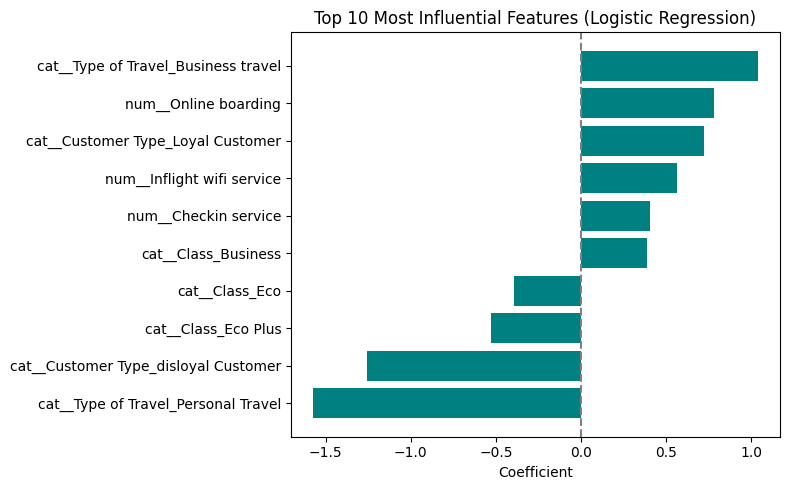

In [10]:
# Select top 10 by coefficient value
top_n = 10
top_features = coef_df.head(top_n).sort_values(by="coefficient")

# Plot
plt.figure(figsize=(8, 5))
plt.barh(top_features["feature"], top_features["coefficient"], color="teal")
plt.axvline(0, color="gray", linestyle="--")
plt.title("Top 10 Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

This is an excellent baseline result.

In [11]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report

hgb_pipe = Pipeline([
    ("prep", preprocess), 
    ("clf" , HistGradientBoostingClassifier(
        learning_rate = 0.05,
        max_depth     = 3,
        max_iter      = 350, 
        l2_regularization = 0.1,
        random_state  = 42
    ))
])

hgb_pipe.fit(X_train, y_train)

val_proba = hgb_pipe.predict_proba(X_val)[:, 1]
val_pred  = hgb_pipe.predict(X_val)

print(f" Validation ROC‑AUC: {roc_auc_score(y_val, val_proba):.3f}")
print(classification_report(y_val, val_pred, digits=3))


 Validation ROC‑AUC: 0.991
              precision    recall  f1-score   support

           0      0.949     0.966     0.958     11776
           1      0.954     0.933     0.943      9005

    accuracy                          0.952     20781
   macro avg      0.952     0.949     0.951     20781
weighted avg      0.952     0.952     0.951     20781



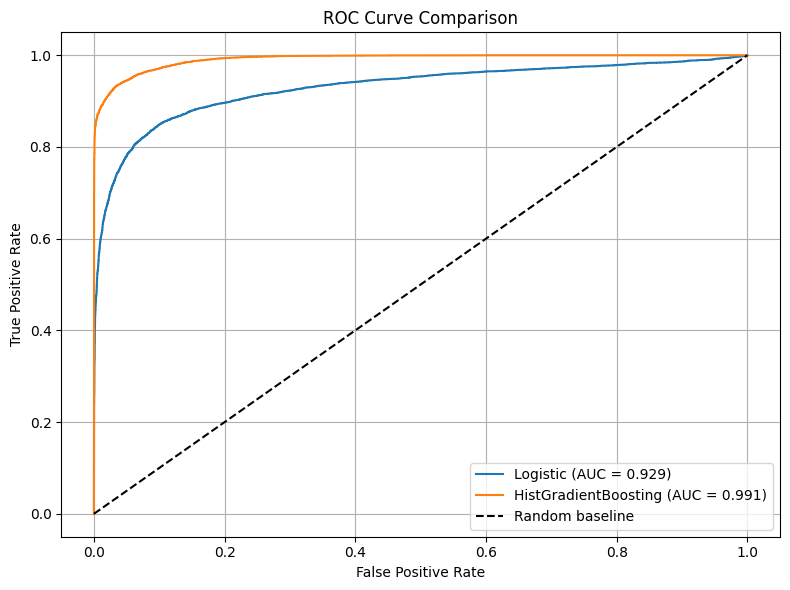

In [12]:


# Get predicted probabilities for both models
log_proba = log_clf.predict_proba(X_val)[:, 1]
hgb_proba = hgb_pipe.predict_proba(X_val)[:, 1]

# Compute ROC curves
fpr_log, tpr_log, _ = roc_curve(y_val, log_proba)
fpr_hgb, tpr_hgb, _ = roc_curve(y_val, hgb_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC = {roc_auc_score(y_val, log_proba):.3f})")
plt.plot(fpr_hgb, tpr_hgb, label=f"HistGradientBoosting (AUC = {roc_auc_score(y_val, hgb_proba):.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
